# MD simulation at constant N,V,E 

### Molecular dynamics simulation of Lennard-Jones particles in the (N, V, E)

## Part 1

In [1]:
import numpy as np  # numerical python, to perform algebra operation
from numba import double, jit, types # numba, optimize CPU and GPU functions, to reduce programming time and increases Python's extensibility
import matplotlib.pyplot as plt # a plotting library for the Python programming language 

# define some constants

def getParams(rho):
    params = np.zeros(4)         # creates an array with four elements, all is zeros.
    rCut = 2.5                   # cutoff radius in L-J potential, and its value is 2.5
    params[0] = rCut             # assignment of 1st element is cutoff radius
    params[1] = rCut*rCut        # assignment of 2nd element is rCut^2
    rc2i = 1.0/params[1]         # 1/rCut^2 
    rc6i = rc2i*rc2i*rc2i        # 1/rCut^6
    params[2] = rc6i*(rc6i-1.0)  # assignment of 3rd element is 1/rCut^6 * (1/rCut^6 - 1)
    
    params[3] = (16.0/3.0)*np.pi*rho*rho*((2.0/3.0)*(np.power(rCut,-9.0))-np.power(rCut,-3.0)) # assignment of 4th element is for the tail correction function of pressure
    
    return params

def getData(): # creates lists to store kinetic energy, potential energy, pressure, temperature, time(x-axis), for plotting.
    data = {}
    data['eKin'] = []   
    data['ePot'] = []
    data['pres'] = []
    data['temp'] = []
    data['time'] = []
    return data
    

@jit(types.Tuple((double, double))(double[:,:]),nopython=True)
def getKinetic(V):
    
    n_atoms = len(V[0])     #  the first element of V[] is the number of atoms, see initialize_velocities(n_atoms,temp) below
    kTot = 0.0              #  kinetic energy with initial value of 0
    temp = 0.0              #  temperature with initial value of 0
    
    
    for i in range(n_atoms):
        kTot += V[0,i]*V[0,i] + V[1,i]*V[1,i] + V[2,i]*V[2,i]  
        kTot = kTot / 2
            #  ith atom to nth atom, and add their kinetic energy together to find the total kinetic energy
            #  v[0] refers to velocity in x direction, v[1] for y direction, and v[2] for z direction 
            #  kTot=1/2(m)v^2, where particle mass: m=1
        temp = (2 * kTot) / (3 * n_atoms)  # thermal EoS: U=3/2*NRT, so T=(2*U)/(3*N), R=1. Atomic Unit. 

    return kTot,temp
    

We create a shifted-truncated Lennard-Jones potential. This potential is set to 0 (“truncated”) beyond the distance. Thus, only consider the part for $r<r_{c}$. Hence, the shifted-truncated Lennard-Jones(STLJ) potential is


$$V_{STLJ}(r)=V_{LJ}(r)-V_{LJ}(r_{c})=4\epsilon[(\frac{\sigma}{r})^{12}-(\frac{\sigma}{r})^6]-V_{LJ}(r_c)$$


with a cutoff of $r_c=2.5\sigma$ and $V_{LJ}(r_c)$ is a shift in the potential to make the energy continuous at the cutoff.  We may use Atomic Units and treat $\sigma=1 $ and $\epsilon=1k_bT$. 

Potential: $$V_{STLJ}(r)=4\epsilon[(\frac{\sigma}{r})^{12}-(\frac{\sigma}{r})^6]-V_{LJ}(r_c)$$

Force: $$F = -\nabla V_{STLJ}(r) = -\frac {\partial V_{STLJ}}{\partial r} (\frac {x}{r} \vec {i} + \frac {y}{r} \vec {j} + \frac {z}{r} \vec {k})$$  where $$-\frac {\partial V_{STLJ}}{\partial r} = (48 \frac {1}{r^{13}} - 24 \frac {1}{r^7}) k_B T$$

Force: $$ F= (48 \frac {1}{r^{14}} - 24 \frac {1}{r^8}) k_B T (x \vec {i} + y \vec {j} + z \vec {k})$$

In [60]:
@jit(types.Tuple((double[:,:], double, double))(double[:,:], double[:], double[:]),nopython=True)

def lennardjones(U, box, params):
    
    n_atoms = len(U[0])

    f = np.zeros((3, n_atoms))  # create a matrix of 3 rows, n_atoms columns, indicating force in 3 directions for each particle.

    ePot = 0.0         # potential energy with initial value of 0
    vir = np.zeros(3)  # creates a list to store the virial contribution to pressure in each dimension
    virTotal = 0.0     # initial virial term is zero

    for i in range(n_atoms):
        for j in range(n_atoms):
            
            if i > j:

                dx  = U[0,j] - U[0,i]   # finds the position difference in x dimension of two atoms
                dy  = U[1,j] - U[1,i]   # finds the position difference in y dimension of two atoms
                dz  = U[2,j] - U[2,i]   # finds the position difference in z dimension of two atoms

                dx  -= box[0] * np.rint(dx/box[0])  # periodic boundary conditions for each dimension with ''rint'': rounds elements of the array to the nearest integer 
                dy  -= box[1] * np.rint(dy/box[1])  # for y dimension
                dz  -= box[2] * np.rint(dz/box[2])  # for z dimension

                r2 = dx*dx + dy*dy + dz*dz  # r2 is the distance^2 within one period of boundary 

                if(r2 < params[1]):    # params[1] = rCut*rCut, only consider particle interaction within cut off radius
                
                    r2i = 1.0 / r2     #1/r^2
                    r6i = r2i*r2i*r2i  #1/r^6

                    ePot = ePot + r6i*(r6i-1.0) - params[2]  
                    # calculates potential energy by adding the L-J potential, only consider particle interaction within cut off radius
                    # assumes sigma=1; doesn't include 4*epsilon yet
                    # params[2] = rc6i*(rc6i-1.0)=V_{LJ}(r_c) is a shift in the potential to make the energy continuous at the cutoff

                    ftmp = 48.0 * r6i*(r6i-0.5) * r2i  # calculates the force between each pair of particles
                    
                    fx = ftmp * dx  # calculates the force in x dimension
                    fy = ftmp * dy  # calculates the force in y dimension
                    fz = ftmp * dz  # calculates the force in z dimension
                    
                    f[0,i] -= fx
                    f[1,i] -= fy
                    f[2,i] -= fz
                    f[0,j] += fx
                    f[1,j] += fy
                    f[2,j] += fz
                    # for any pair of particles [i,j], the direction of interactions between them are opposite in 3 directions
                    
                    vir[0] += fx * dx
                    vir[1] += fy * dy
                    vir[2] += fz * dz
                    # the second virial coefficient (B2) represents how binary interactions between molecules increase pressure
                    # vir here is the L-J energy's contribution to pressure
                    # the unit of vir is energy(force*position)(J=N·m)
                    
                    
    ePot = ePot * 4.0         # calculates L-J potential; epsilon=1
    virTotal = np.mean(vir)   # averages the virial 
    
    return f,ePot,virTotal    #  force between any pair of particles, potential energy, virial




def initialize_positions(n_atoms, rho):
    
    pos = np.zeros((3, n_atoms))   # create a matrix of 3 rows, n_atoms columns, indicating positions in 3 directions for each particle.

    nPerDim = int(np.ceil(pow(n_atoms,(1.0/3.0))))  # the number of atoms in each dimension, assume all the atoms are enevly distributed in the box.
    vol = n_atoms/rho                               # rho: volume density=the number of atoms in the box volume / box volume
    lenWhole = np.power(vol,(1.0/3.0))              # the length of each direction of the box
    
    counter = 0
    for i in range(0,nPerDim):
        for j in range(0,nPerDim):
            for k in range(0,nPerDim):
                if (counter < n_atoms): # record x, y, z position of each atom
                    
                    pos[0,counter] = (i+0.5)*lenWhole/nPerDim # the interval of each atom is 1 bond length in x direction. 
                    pos[1,counter] = (j+0.5)*lenWhole/nPerDim # the interval of each atom is 1 bond length in y direction
                    pos[2,counter] = (k+0.5)*lenWhole/nPerDim # the interval of each atom is 1 bond length in z direction
                    
                    counter += 1
                    
    return pos



def initialize_box(n_atoms, rho):
    
    box = np.zeros(3)                     # creates a list to store length of 3 directions of the box
    vol = n_atoms/rho                     # rho: volume density=the number of atoms in the box volume / box volume
    lenWhole = np.power(vol,(1.0/3.0))    # length of each direction of the box
    box[0] = box[1] = box[2] = lenWhole   # it's a cubic box
    return box


def initialize_velocities(n_atoms,temp):

    vel = np.random.normal(0.0,np.sqrt(temp),(3,n_atoms))  # Gaussian distribution with mean=0, deviation = square root of T, size=3*n  
    mean = np.mean(vel,axis=1)  # calculates the average velocity in each direction
    for i in range(3): 
        vel[i] -= mean[i] 
    return vel


@jit(double[:,:](double[:,:], double, double),nopython=True)
def scale_velocities(vel,target,temp):

    factor = np.sqrt(target/temp)  
    return vel*factor




### Main program for MD

$$ p = \sum_{i=1}^{n_{tot}}p_{block}$$


$$ p_{block} = \rho T + \frac{virial}{V_{box}}+ \Delta p^{tail} $$
In general, the pressure is calculated from the temperature and virial series. <br>
1. $p_{block}$ represents each block of pressure. The number of blocks equal to the total number of steps in equilirbium and production.
2. Density $\rho$ is the initialized value. (Roc)
3. Temperature $T$ is calculated from the formula in $Part 2$ for each step.
4. Virial contribution is calculated from the formula in Lennard-Jones potential session.
5. $V_{box}$ is the volume of the box, equals to $\frac{N_{particle}}{density}$
6. $\Delta p^{tail}$ is the tail correction function of pressure, given by $\frac{16}{3} \pi \rho^2( \frac{2}{3}r_c^{-9}-r_c^{-3}) $

In [61]:
def runSimulation(temperature, n_atoms, rho, n_steps_eq, n_steps_prod): # 5 variables: T, N, density, 2 steps 
    
    pos = initialize_positions(n_atoms, rho)           # a matrix of 3 rows, n_atoms columns, indicating positions in 3 directions for each atom
    box = initialize_box(n_atoms, rho)                 # a list with 3 length of 3 directions of the box
    vel = initialize_velocities(n_atoms, temperature)  # based on the initial T,  generates the initial velocity of n atoms
    params = getParams(rho)                            # creates some constants based on rho 
    data= getData()                                    # creates some lists to store kinetic energy, potential energy, pressure, temperature, time
    
    
    if (box[0] < 2*params[0]): # if the length of each direction of the box < 2*rCut
        print("Box size too small. Try adding more atoms or reducing the density.")
    return
    
    n_steps_tot = n_steps_eq + n_steps_prod  # there are 2 stages in MD: 1) equilibrium stage; 2) production stage
    
    blockTemp = 500   # constant only, every 500 steps
    blockData = 50    # constant only, every 50 steps
    dt = 0.0005       # time step

    
    force,ePot,virial = lennardjones(pos,box,params)  # calls the function and return to the initial values of force, potential energy, and virial contribution
    
    
    tempBlock = 0.0  # creates a container for temperature, its value will update at each time.
    presBlock = 0.0  # creates a container for pressure, its value will update at each time.

    print("Starting equilibration...")  
    
    for i in range(n_steps_tot):  # i from 0 to total steps-1
        
        if i == n_steps_eq:  # notes that equilibrium has been reached 
            print("Finished equilibration, beginning production...")
        
        
        pos += vel * dt + 0.5 * force * dt * dt  # updates the position for each atom with dynamic formula, m=1
        
        force0 = force[:]                   # copies the force from the previous step
        
        force,ePot,virial = lennardjones(pos, box, params)  # update force, potential energy, virial term for the step
     
        vel += 0.5 * (force + force0) * dt  # updates the velocity for each atom with dynamic formula, m=1
     
        kTot,temp = getKinetic(vel)         # calculates kinetic energy and temperature based on velocity
        
        tempBlock += temp                   # adds up temperature from all atoms
        
        presBlock += (rho*temp) + (virial/(box[0]*box[1]*box[2])) + params[3]   # calculates pressure; 1st term is for an ideal gas, 2nd term accounts for nonideality, 3rd is cutoff; k=1
        
        
        if (i+1)%blockData == 0:           # updates "data" every 50 steps, i from 0 to total steps-1
            data['eKin'].append(kTot)      # updates kinetic energy datalist
            data['ePot'].append(ePot)      # updates potential energy datalist
            data['temp'].append(temp)      # updates temperature datalist
            data['pres'].append(presBlock/blockData) # updates pressure datalist; each datapoint is average pressure over 50 steps 
            data['time'].append((i+1)*dt)  # updates time datalist
            presBlock = 0.0                # resets pressure summation to zero
                                   
        if (i+1)%blockTemp == 0 and i < n_steps_eq:  # every 500 steps, and still within the equilibrium stage
            avgTemp = tempBlock/blockTemp  # calculates the average temperature of every 500 steps
            vel = scale_velocities(vel,temperature,avgTemp) # scales velocities based on temperature 
            tempBlock = 0.0                # resets temperature summation to zero
     
        if (i+1)%5000 == 0 and (i+1) <= n_steps_eq: 
            print("{0:.2f}% done".format((i+1)*100/n_steps_eq))
            
        if (i+1)%5000 == 0 and (i+1) > n_steps_eq:  
            print("{0:.2f}% done".format((i+1-n_steps_eq)*100/n_steps_prod))

    return data

        

## Part 2

Based on your understanding of the code, write an expression below that relates temperature to particle velocities in the cell below (using markdown).

$$
K_{tot} = \frac{3}{2} NKT
$$
$$
K_{tot} = \frac{1}{2}\sum_{i=0}^N{ (v_{ix}^2 +  v_{iy}^2 +  v_{iz}^2)}
$$
Thus, we know that
$$
T = \frac{1}{3Nk} {\sum_{i=0}^N{ v_{ix}^2 +  v_{iy}^2 +  v_{iz}^2}}
$$

## Part 3

Test your documented code by running a simulation.  The code snippet below shows a sample input for the program; you may wish to run the simulation for more/fewer timesteps or with more/fewer particles.  In general, you will obtain more statistically meaningful results with longer/larger simulations (i.e. more data!), but it will take longer to run. The density $N/V$ should be in the range 0.05-0.3 and the temperature $T^*$ should be in the range 1.5-2.0.

In the cells below, use python's graphing packages to show that after a brief "equilibration" period, your code leads to stable average values of kinetic/potential energy, temperature, and pressure. Verify that the total energy is conserved during the "production" portion of the simulation.

In [62]:
temperature = 1.5
n_atoms = 200
density = 0.2
eq_steps = 5000
prod_steps = 5000
data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)

Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done


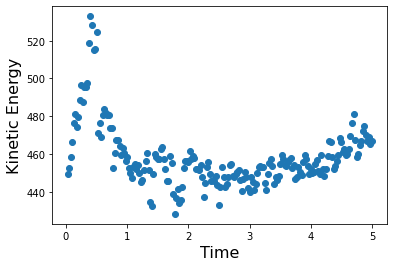

In [63]:
# example plot
plt.scatter(data["time"], data["eKin"])
plt.xlabel("Time", fontsize=16)
plt.ylabel("Kinetic Energy", fontsize=16)
plt.show()

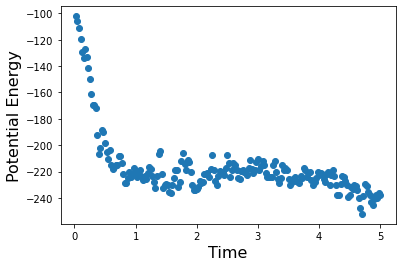

-237.81946586754452


In [64]:
# Potential Energy vs Time
plt.scatter(data["time"], data["ePot"])
plt.xlabel("Time", fontsize=16)
plt.ylabel("Potential Energy", fontsize=16)
plt.show()
print(data["ePot"][-1])

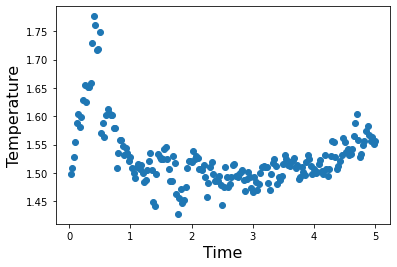

In [65]:
# Temperature vs Time
plt.scatter(data["time"], data["temp"])
plt.xlabel("Time", fontsize=16)
plt.ylabel("Temperature", fontsize=16)
plt.show()

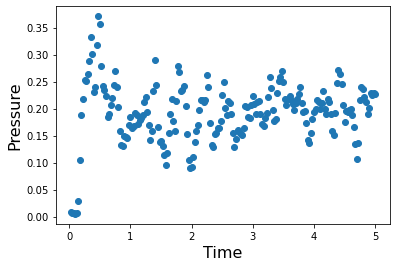

0.22769477318328557


In [66]:
# Pressure vs Time
plt.scatter(data["time"], data["pres"])
plt.xlabel("Time", fontsize=16)
plt.ylabel("Pressure", fontsize=16)
plt.show()
print(data["pres"][-1])

## Part 4

We typically use a "cut-off" radius $r_{c}$ to speed up calculation - particles separated by distances larger than this value do not exert forces on one another.  However, $r_{c}$ cannot be larger than half of the box length.  Why is that?  Answer in the cell below (using markdown).


If there is a particle A, and another particel B. Assume the particle B is out of the box, it will be replaced by another particle B' in the box to have the same interaction with particel A, based on periodic boundary conditions. If the distance between A and B equals to $r_{c}$, so we won't consider the interaction between A and B. However, if $r_{c}$ is larger than half of the box length, then the distance between particle A and particle B' is smaller than half of the box length, which is also within the cut-off radious $r_{c}$, so we should consider the interaction between particle A and particle B. Obviously it's contradictory.  

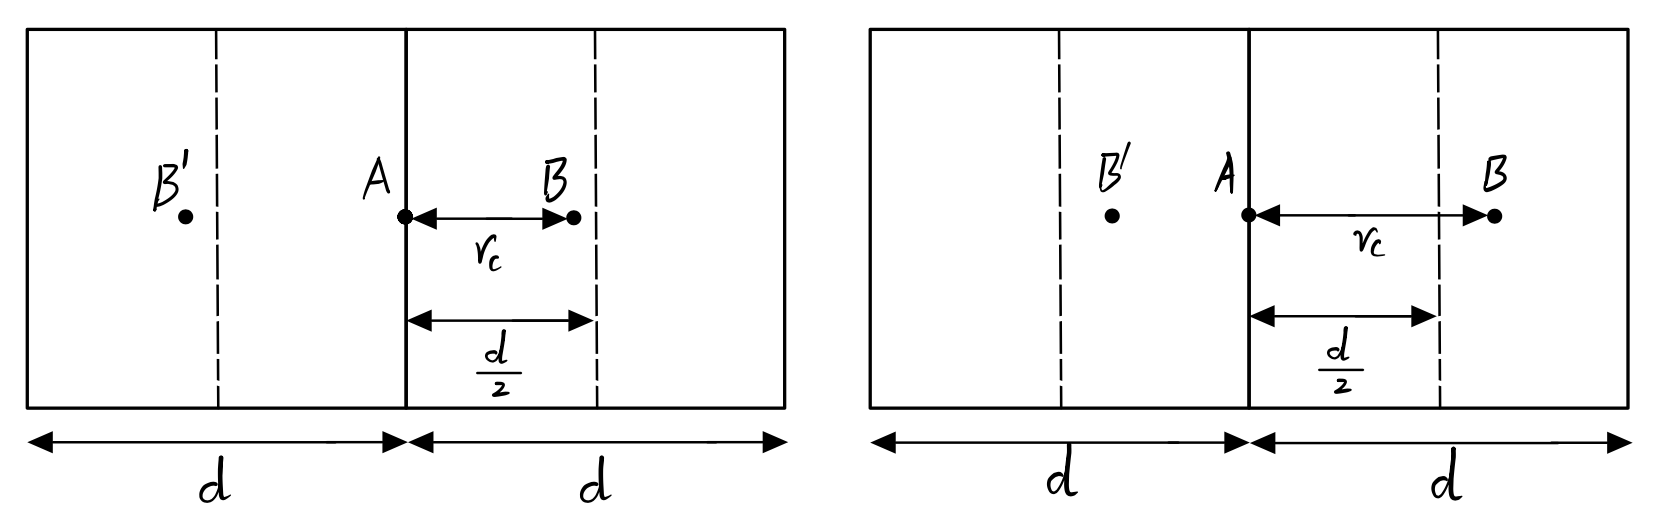

## Part 5 

By examining your code, explain how the pressure of the Lennard-Jones fluid is calculated. How does the pressure arise in the system?


$$ p = \sum_{i=1}^{n_{tot}}p_{block}$$


$$ p_{block} = \rho T + \frac{virial}{V_{box}}+ \Delta p^{tail} $$
In general, the pressure is calculated from the temperature and virial series. <br>
1. $p_{block}$ represents each block of pressure. The number of blocks equal to the total number of steps in equilirbium and production.
2. Density $\rho$ is the initialized value. (Roc)
3. Temperature $T$ is calculated from the formula in $Part 2$ for each step.
4. Virial is calculated from the formula in Lennard-Jones potential session.
5. $V_{box}$ is the volume of the box, equals to $\frac{N_{particle}}{density}$
6. $\Delta p^{tail}$ is the tail correction function of pressure, given by $\frac{16}{3} \pi \rho^2( \frac{2}{3}r_c^{-9}-r_c^{-3}) $

# Section Two - Connecting with Reality

Your program operates in "reduced units."  These units are related to real quantities through the following equations:

$$ T^* = \frac{k_B T}{\epsilon} $$

$$ \rho^* = \sigma^3 \rho $$

$$ t^* = t \sqrt{\frac{\epsilon}{m\sigma^2}} $$

where $m$ is the mass of the particles. The code (as provided) implicitly uses $\sigma = 1$ and $\epsilon=1$. The reason for using these vales is based on the principle of corresponding states; any two fluids interacting through a LJ potential behave in exactly the same way, provided you compare their properties in the appropriately reduced units. For instance consider fluid $A$ with $\sigma_A = 1$ and fluid $B$ with $\sigma_B = 2$. You could use the results of your simulation with $\sigma = 1$ (i.e. fluid $A$ at a given density (say $\rho_A^* = 0.5$) to determine the properties of the other fluid at a different density ( $\rho_B^* = 0.5/\sigma_B^3 = 0.125$)

$\rho$ has the unit of $atoms·Ang.^{-3}$. Hence, $\rho^*=\rho \sigma^3$ has the unit of $atoms$, we may regard $\rho^*$ as a pure number, that represents the number of atoms.


## Part Six

Based on the definitions of reduced units above, provide a definition of the reduced pressure in the cell below (in markdown).

Considering $p_{block} = \rho T  + virial \text{ } terms$
$$p^* \approx T^* \rho^*=\frac{k_B T}{\epsilon}  \sigma^3 \rho  \approx \frac{pσ^3}{ϵ} $$ 
Where
$$p=T \rho$$
Hence,
$$p^* =\frac{pσ^3}{ϵ} $$ 

## Part Seven

Let's say we're interested in the properties of methane, whose Lennard-Jones parameters are shown below.

$$ \sigma = 3.73 \text{Ang.}$$


$$ \frac{\epsilon}{k_B} = 147.9 K $$

Based on this data, what was the size of the timestep you used in Part 3 above in real units (seconds)? How long was your simulation, also in real units? What were the real values of temperature and pressure of your system (in $K$ and bar, respectively)?  Answer in the cell below.

$\rho$ has the unit of $atoms·Ang.^{-3}$. Hence, $\rho^*=\rho \sigma^3$ has the unit of $atoms$, we may regard $\rho^*$ as a pure number, that represents the number of atoms.


$k_B=1.381\times 10^{-23} J/K$


Let's choose:  $T^* = 1.5,  \rho^* = 0.2mol$

There are 5000 steps for equilibrium and 5000 steps for production, so the total timesteps is 10000.

$ t^* =10000 \times 0.0005=5  $

$$ T = \frac{\epsilon T^* }{k_B} =147.9 K \times 1.5 = 221.85 K $$

$$ \rho = \frac{\rho^*}{\sigma^3}=\frac{\rho^*}{(3.73 \times 10^{-10} m)^3}=1.927\times 10^{28}\rho^* m^{-3}$$

Hence, there are $1.927\times 10^{28} \rho^*$ atoms per $m^3$ , namely $\frac{1.927\times 10^{28} \rho^* atoms/m^3}{6.02 \times 10^{23} atoms/mol}=0.32\rho^*\times 10^5 mol/m^3$

After 10000 time steps, $p^* = 0.1677$ (P.S. each time would be different because of the different initial conditions) 

$$p =\frac{p^*ϵ}{σ^3}=\frac{0.1677 \times 147.9 K \times 1.381 \times 10^{-23} J/K}{(3.73 \times 10^{-10} m)^3} = 6.6 \times 10^6 N/m^2 = 66.00   bar $$ 

For mathane, 

$$m = \frac{M}{N_A}= \frac{16  g/mol}{6.02 \times 10^{23} /mol}=2.66 \times 10^{-23} g $$


$$ t = t^* \sqrt{\frac{m\sigma^2}{\epsilon}} = 5 \times \sqrt{\frac{2.66 \times 10^{-23} \times 10^{-3} Kg  \times (3.73 \times 10^{-10}m)^2}{147.9 K \times 1.381 \times 10^{-23} J/K}} =6.73 \times 10^{-12}s $$



## Part Eight

The (truncated) virial equation of state for methane is given below:

$$ P = \rho R T \left ( 1 + B \rho_r \right ) $$

$$ B = B_0 + \frac{B_1}{T_r} + \frac{B_2}{T_r^2} + \frac{B_3}{T_r^3}$$

$$ B_0 = 0.440 \\ B_1 = -1.171 \\ B_2 = -0.236 \\ B_3 = -0.210 $$

where $\rho_r \equiv \rho/\rho_c$ is the density relative to the critical density and $T_r = T/T_c$ is the temperature relative to the critical temperature. For methane, $\rho_c = 10.1 mol/L$ and $T_c = 190.6 K$. 
In the cell(s) below, verify the accuracy of this equation at a reduced temperature of $T^* = 2.0$. For what values of $\rho$ does it break down? To answer this question, you will need to run the simulation at several densities in the range of $\rho = 0.05-0.3$. Compare the pressure obtained in simulations to that predicted by the virial equation. Create a plot of simulated and predicted pressures as a function of density. Perform all calculations in reduced units and explain your results.



$k_B=1.381\times 10^{-23} J/K$

$R=8.314 J·K^{-1}·mol^{-1}$

$$ T = \frac{\epsilon T^* }{k_B} =147.9 K \times 2.0 = 295.8 K $$

$$T_r = T/T_c =\frac{295.8 K}{190.6 K} = 1.552$$ 

$$ \rho = \frac{\rho^*}{\sigma^3}=\frac{\rho^*}{(3.73 \times 10^{-10} m)^3}=1.927\times 10^{28}\rho^* m^{-3}$$

Hence, there are $1.927\times 10^{28} \rho^*$ atoms per $m^3$ , namely $\frac{1.927\times 10^{28} \rho^* atoms/m^3}{6.02 \times 10^{23} atoms/mol}=0.32\rho^*\times 10^5 mol/m^3$

$$\rho_r = \rho/\rho_c=\frac{0.32\rho^*\times 10^5 mol/m^3}{10.1 \times 1000 mol/m^{3}}=3.17\rho^*$$ 

Here, $\rho_r$ is a pure number.

$$ B = B_0 + \frac{B_1}{T_r} + \frac{B_2}{T_r^2} + \frac{B_3}{T_r^3} = 0.440-\frac{1.171}{1.552}-\frac{0.236}{1.552^2}-\frac{0.210}{1.552^3} = -0.4687 $$


$$ P = \rho R T \left ( 1 + B \rho_r \right )=0.32\rho^*\times 10^5 mol/m^3\times 8.314 J·K^{-1}·mol^{-1} \times 295.8 K\times (1-0.4687 \times 3.17\rho^*)$$
$$=7.87 \rho^*\times (1-1.486 \rho^*) \times 10^7 Pa $$


$\rho^*$ is a pure number above

$$p^* =\frac{pσ^3}{ϵ} =\frac{7.87 \rho^*\times (1-1.486 \rho^*) \times 10^7 Pa \times (3.73 \times 10^{-10}m)^3}{147.9 K \times 1.381\times 10^{-23}J·K^{-1}} =2\rho^* \times (1-1.486\rho^*) $$

Here, $p^*$ is a pure number.

## Part Nine

Now we are interested in comparing our simulation results to experimental values.  For a reduced temperature of $T^* = 2.0$, simulate a broader range of densities $\rho^* = 0.05 - 0.5$. Now, use the [NIST Chemistry WebBook](https://webbook.nist.gov/chemistry/fluid/) to obtain experimental values for the pressure of methane at the corresponding real temperature/densitites and plot this data alongside your simulation results and the predictions of the virial equation of state given above.  How does your simulation data compare over the range of densities? Are your simulations more or less accurate than the virial equation?

### Plot the calculated and simulated values of pressure in the dimensionless scale

Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done


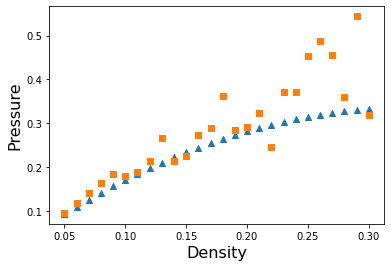

In [67]:
temperature = 2.0  # T=295.8 K
n_atoms = 200
eq_steps = 5000  
prod_steps = 5000

# compare two kind of data
predicted_data = []
simulated_data = []

density_range = np.arange(0.05,0.31,0.01)  # density=0.05-0.5

for density in density_range:
  data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)

  p_predicted=2*density*(1-1.486*density) 
  p_simulated = data["pres"][-1]

  predicted_data.append(p_predicted)  # based on virial equation
  simulated_data.append(p_simulated) # MD simulation

print(predicted_data)
print(simulated_data)

plt.scatter(density_range, predicted_data, marker="^")
plt.scatter(density_range, simulated_data, marker="s")
plt.xlabel("Density", fontsize=16)
plt.ylabel("Pressure", fontsize=16)
plt.show()

From the plot above, we found that the density started from 0.2, the simulated data and predicted data are increasingly different. Simulated data has large deviation as a function of density.

### Plot the calculated,simulated and experimental values of pressure in the dimensionless scale

Transformation from reality unit to reduced unit:

$ \sigma = 3.73 \text{Ang.}$

$\rho$ has the unit of $atoms·Ang.^{-3}$. Hence, $\rho^*=\rho \sigma^3$ has the unit of $atoms$, we may regard $\rho^*$ as a pure number that represents the number of atoms.

$k_B=1.381\times 10^{-23} J/K$

$R=8.314 J·K^{-1}·mol^{-1}$

$ \epsilon/k_B= 147.9 K $

$$ \rho = \frac{\rho^*}{\sigma^3}=\frac{\rho^*}{6.02\times 10^{23} /mol \times(3.73 \times 10^{-10}m)^3}$$

$$\rho^* = \rho  \times  3.12\times 10^{-5} m^3/mol$$

Here, $\rho$ has the unit of $mol/m^3$

$$p =\frac{p^*\epsilon}{\sigma^3}=\frac{p^* \times 147.9 K \times 1.381 \times 10^{-23} J/K}{(3.73 \times 10^{-10} m)^3\times 10^5} = p^*\times 3.93  bar $$ 

$$p^*=\frac{p}{3.93bar}$$

Here, $p$ has the unit of $bar$.

In [74]:
# The unit we choose in NIST: Temperature (K), Pressure (bar), Density (mol/m3)
# from NIST, the unit of exp_x is mol/m^3, the unit of exp_y is bar.

x2=[ 0 for j in range(20) ]
y2=[ 0 for j in range(20) ]

def Trans(x1,y1):
    x2=x1*(3.12*10**-3)
    y2=y1/3.93
    return x2,y2

for i in range(20):
    x2[i],y2[i]=Trans(exp_x[i],exp_y[i])

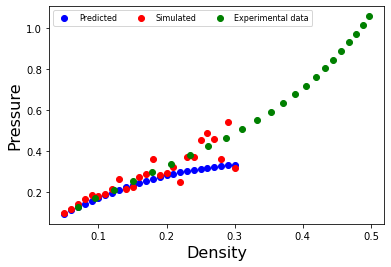

In [73]:
# After transformation from reality unit to reduced unit:
x2=[0.0694,0.0952,0.1222,0.1501,0.1785,0.2069,0.2347,0.2615,0.2869,0.3106,0.3325,0.3528,0.3714,0.3885,0.4043,0.4189,0.4324,0.4450,0.4567,0.4677,0.4780,0.4877,0.4968]
y2=[0.1271,0.1694,0.2117,0.2541,0.2965,0.3388,0.3812,0.4235,0.4658,0.5082,0.5506,0.5929,0.6353,0.6776,0.7199,0.7623,0.8047,0.8470,0.8894,0.9317,0.9740,1.0164,1.0588]

fig1 = plt.scatter(density_range,predicted_data,marker = 'o',color='b')
fig2 = plt.scatter(density_range,simulated_data,marker = 'o',color='r')
fig3 = plt.scatter(x2,y2,marker = 'o',color='g')

plt.legend((fig1,fig2,fig3),
           ('Predicted', 'Simulated', 'Experimental data'),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
          
plt.xlabel("Density", fontsize=16)
plt.ylabel("Pressure", fontsize=16)
plt.show()

From the plot above, we found that the simulated results are much more accurate than the predicted data from virial series, especially when the density is larger than 0.22. Although the simulated results have larger fluctuation at higher density, it matches better with experimental data. 

# Section Three - Chemical Potential

When we studied the canonical ensemble, we found that the chemical potential could be expressed as:

$$ \frac{\mu}{T} = - \left (  \frac{\partial S}{\partial N} \right )_{V,E}$$

In the microcanonical ensemble, the entropy $S$ is related to the number of accessible states $S = k_B ln\Omega(N,V,E)$. It can be shown that in order to calculate the above derivative, one needs to compute $\Omega(N+1,V,E)/\Omega(N,V,E)$, which would be very difficult in ordinary simulations.

An alternative approach was suggested by Benjamin Widom [*J. Chem. Phys.* **39**, 2808-2812 (1963)].  Once an $NVE$ simulation has reached equilibrium, a virtual test particle is placed randomly into the fluid and the change in total internal energy $\Delta U$ is calculated. The test particle is then removed before the simulation is allowed to integrate to the next time step. This process is then repeated throughout the simulation and the "excess" chemical potential is calculated from the following equation:

$$ \mu^{ex} = \mu - \mu^{ideal} = -k_B \langle T \rangle ln \left [ \langle T \rangle^{-3/2} \langle T^{3/2} e^{-\Delta U/k_B T} \rangle \right ] $$





## Part Ten

Using the ideas from the Widom method above, modify the MD code above to calculate the chemical potential of methane (in SI units) at $\rho^* = 0.1$ and $T^* = 2.0$. Perform your calculations at a variety of system sizes, e.g. $N = 100, 200, 500, 1000$. Note that the simulation time scales as $N^2$ so the larger simulations may take some time. Comment on your results. Note that you will need to calculate the ideal component, $\mu^{ideal}$ analytically.

$$ T = \frac{\epsilon T^* }{k_B} =147.9K * 2.0= 295.8K $$

$$ \frac{\epsilon}{k_B} = 147.9 K  $$

$$ μ^{ex} =  -k_B \langle T \rangle ln \left [ \langle T \rangle^{-3/2} \langle T^{3/2} e^{-\Delta U/k_B T} \rangle \right ]=-1.381·10^{-23} J·mol^{-1}·K^{-1}\langle T \rangle ·ln  [ \langle T \rangle^{-3/2}· 295.8^{3/2}·exp(\frac{\Delta U}{4.08\times10^{-21}})  ]$$ 

The ideal component of gas potential energy is estimated to be the one mole of standard Gibbs free energy at given temperature.
$$\mu_{ideal \text{ } per \text{ } molecule} = \frac{-5.05\times 10^4 J/mol}{6.02\times 10^{23}/mol} =-8.39 \times 10^{-20}J$$ 

In [17]:
#When n_atoms = 100

temperature = 2.0
n_atoms = 100
eq_steps = 5000
prod_steps = 5000
density = 0.1

natoms_range = np.arange(n_atoms,-1,-1)
ideal_mu = -8.39*10**(-20)

excess_mu = 0
data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)

for i in natoms_range:
  E_pot1= data["ePot"][-1]
  data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)
  E_pot2= data["ePot"][-1]
  deltaU= (E_pot1-E_pot2)*2.042*10**(-21)
  average_temp=data["temp"][-1]
  excess_mu += -1.381*10**(-23)*average_temp*np.log((average_temp)**(-1.5)*5087.4*np.exp(deltaU/(4.08*10**(-21))))
  print(i,deltaU,average_temp,excess_mu)
  n_atoms -= 1
  if (n_atoms/density)**(1/3) < 5:
    break
print("final ideal energy is",ideal_mu*100 + excess_mu)

Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
100 1.2392554261906274e-20 2.0698294582885692 -2.994992953992169e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
99 1.6091778429916083e-20 2.1283245082477418 -6.3285696060045395e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
98 -3.9292460112765335e-20 1.9616309215983905 -5.760431569811544e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
97 -2.8548470251609313e-21 1.9853855454877647 -7.626723749006506e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
96 -1.969657853160622e-21 1.9874617226448885 -9.554027102368093e-22
Starting equilibration...
100.00% done
Finished equilibr

In [18]:
#When n_atoms = 200

temperature = 2.0
n_atoms = 200
eq_steps = 5000
prod_steps = 5000
density = 0.1

natoms_range = np.arange(n_atoms,-1,-1)
ideal_mu = -8.39*10**(-20)

excess_mu = 0
data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)

for i in natoms_range:
  E_pot1= data["ePot"][-1]
  data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)
  E_pot2= data["ePot"][-1]
  deltaU= (E_pot1-E_pot2)*2.042*10**(-21)
  average_temp=data["temp"][-1]
  excess_mu += -1.381*10**(-23)*average_temp*np.log((average_temp)**(-1.5)*5087.4*np.exp(deltaU/(4.08*10**(-21))))
  print(i,deltaU,average_temp,excess_mu)
  n_atoms -= 1
  if (n_atoms/density)**(1/3) < 5:
    break
print("final ideal energy is",ideal_mu*200 + excess_mu)

Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
200 -7.478052385176233e-21 2.0267507788695474 -1.579670288202508e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
199 -9.412721918569126e-21 1.9850944209266925 -3.0055468750371746e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
198 2.2916525316486684e-20 2.044918401416213 -6.697342045565891e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
197 -2.6476938566631377e-20 2.023060709350747 -6.975194322925135e-22
Starting equilibration...
100.00% done
Finished equilibration, beginning production...
100.00% done
196 2.245152211805547e-20 1.9967980768931628 -1.0558567621360523e-21
Starting equilibration...
100.00% done
Finished equilib

In [ ]:
#When n_atoms = 500

temperature = 2.0
n_atoms = 500
eq_steps = 5000
prod_steps = 5000
density = 0.1

natoms_range = np.arange(n_atoms,-1,-1)
ideal_mu = -8.39*10**(-20)

excess_mu = 0
data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)

for i in natoms_range:
  E_pot1= data["ePot"][-1]
  data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)
  E_pot2= data["ePot"][-1]
  deltaU= (E_pot1-E_pot2)*2.042*10**(-21)
  average_temp=data["temp"][-1]
  excess_mu += -1.381*10**(-23)*average_temp*np.log((average_temp)**(-1.5)*5087.4*np.exp(deltaU/(4.08*10**(-21))))
  print(i,deltaU,average_temp,excess_mu)
  n_atoms -= 1
  if (n_atoms/density)**(1/3) < 5:
    break
print("final ideal energy is",ideal_mu*500 + excess_mu)

In [ ]:
#When n_atoms = 1000
temperature = 2.0
n_atoms = 1000
eq_steps = 5000
prod_steps = 5000
density = 0.1

natoms_range = np.arange(n_atoms,-1,-1)
ideal_mu = -8.39*10**(-20)

excess_mu = 0
data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)

for i in natoms_range:
  E_pot1= data["ePot"][-1]
  data = runSimulation(temperature, n_atoms, density, eq_steps, prod_steps)
  E_pot2= data["ePot"][-1]
  deltaU= (E_pot1-E_pot2)*2.042*10**(-21)
  average_temp=data["temp"][-1]
  excess_mu += -1.381*10**(-23)*average_temp*np.log((average_temp)**(-1.5)*5087.4*np.exp(deltaU/(4.08*10**(-21))))
  print(i,deltaU,average_temp,excess_mu)
  n_atoms -= 1
  if (n_atoms/density)**(1/3) < 5:
    break
print("final ideal energy is",ideal_mu*1000 + excess_mu)